This notebook goes through the process on how to do create a **pawn (chess)**.

# IMPORTS

In [21]:
import numpy as np
import matplotlib.pyplot as plt

import plotly.graph_objects as go

from spomso.cores.helper_functions import generate_grid, smarter_reshape
from spomso.cores.post_processing import hard_binarization
from spomso.cores.geom_3d import Cylinder, Sphere, Cone
from spomso.cores.combine import CombineGeometry

# PARAMETERS

In [22]:
# size of the volume
co_size = 1.4, 1.4, 2.2
# resolution of the volume
co_resolution = 100, 100, 200

show = "FIELD" # BINARY, FIELD
show_midplane = True
show_3d = False

# COORDINATE SYSTEM

Point cloud of coordinates is created with the **generate_grid** function, which takes the size of the coordinate system and the number of points in each direction (**co_resolution**).

In [23]:
coor, co_res_new = generate_grid(co_size, co_resolution)

If there is an even number of points along any direction the function will automatically convert it to an odd number, therefore the origin is always included in the point cloud. The point cloud is a numpy.ndarray with a shape of **(D, N)**, where **D** is the number of dimensions and **N** is the number of data points.

# CREATE SDFs

## Torso

Define the torso of a *chess pawn* as a **cone** with a **height** of **1.2** and the slope angle of **$\pi$/10**:

In [24]:
torso = Cone(1.2, np.pi/10)

**Position** the **torso** in space:

In [25]:
torso.move((0, 0, -0.55))

**Round** the **torso** with the **rounding radius** of **0.1** while preserving its **maximum radius** of **0.4**:

In [26]:
torso.rounding_cs(0.1, 0.4)

<function spomso.cores.modifications.ModifyObject.rounding_cs.<locals>.new_geo_object(co, *params)>

## Base

Define the **base** of the **pawn** as a **cylinder** with a **radius** of **0.4** and a **height** of **0.07**:

In [27]:
base = Cylinder(0.4, 0.07)

**Round** the **cylinder** with the **rounding radius** of **0.1** and **position** it in space:

In [28]:
base.rounding(0.1)
base.move((0, 0, -0.95))

## Head

Define the **head** as a **sphere** with a **radius** of **0.25** and **position** it at the top of the **torso**:

In [29]:
head = Sphere(0.25)
head.move((0, 0, 0.6))

## Collar

Define the **collar** (rim below the head of the pawn) as a **cylinder** with **radius** of **0.3** and **height** of **0.05**:

In [30]:
collar = Cylinder(0.3, 0.05)

**Position** the **collar** below the **head**:

In [31]:
collar.move((0, 0, 0.25))

## Combine Objects

Define the **union** of two objects as an **UNION2** operator:

In [32]:
union = CombineGeometry("UNION2")

**Merge (union)** the **box** and the **arc** into geometry **s1**, and **merge** the **hexagon** and the **cylinder** into geometry **s2**. The **s1** geometry will be the **base** from which **s2** geometry is **subtracted**.

Apply the **union** on to the **base** and the **torso**, and then apply the **union** once again on the **result of the previous union** and the **head**:

In [33]:
p1 = union.combine(base, torso)
statue = union.combine(p1, head)

**NOTE:** **union** could also be defined as an **UNION** operator which can take multiple objects as an input. Here the **UNION2** was applied twice just to demonstrate that the operator (once defined) can be reused.

Define the **SMOOTH_UNION2_2** operator with which the **collar** and the rest of the **pawn** will be combined. There will be a smooth transition between the **collar** and the rest of the **pawn**:

In [34]:
smooth_union = CombineGeometry("SMOOTH_UNION2_2")

Smooth union with the **smoothing width** of **0.2**:

In [35]:
pawn = smooth_union.combine_parametric(statue, collar, parameters=0.2)

**Position** the **pawn** in space:

In [36]:
pawn.move((0, 0, 0.2))

## EVALUATE

Evaluate the SDF of the **pawn** to create a signed distance field 3D map. This is done by calling the **create** method and passing in the point cloud of coordinates:

In [37]:
pawn_pattern = pawn.create(coor)

# BINARIZATION

Convert the distance field to a binary voxel map, where 1 corresponds to the interior and 0 to the exterior of the geometry.

In [38]:
if show_midplane:
    field = smarter_reshape(pawn_pattern, co_resolution)
    if show=="BINARY":
        pattern_2d = hard_binarization(field, 0)

if show=="BINARY":
    pattern = hard_binarization(pawn_pattern, 0)

# PLOT

Drawing results...


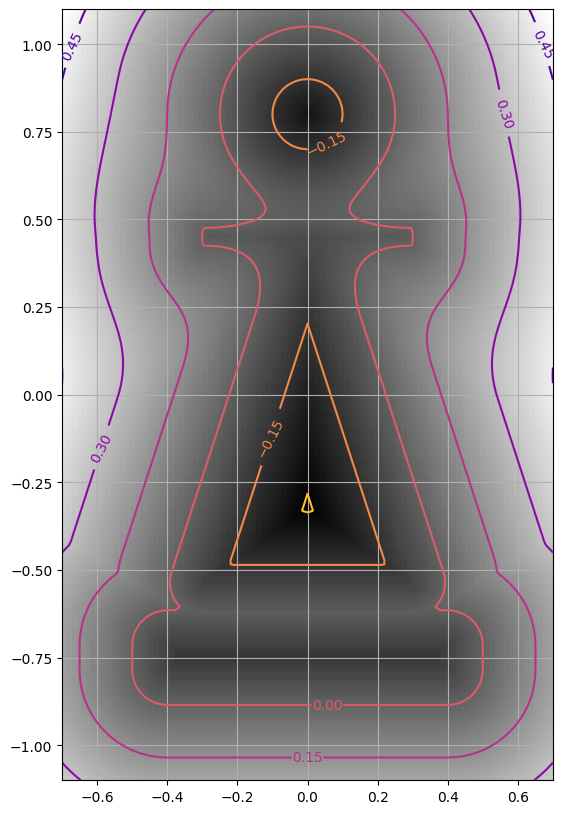

In [39]:
print("Drawing results...")
# Mid-plane cross-section plot
if show_midplane and show=="BINARY":
    fig, ax = plt.subplots(1,1, figsize=(8.25, 8.25))
    ax.imshow(pattern_2d[:, co_resolution[1]//2, :].T,
              cmap="binary_r",
              extent=(-co_size[0]/2, co_size[0]/2,
                      -co_size[2]/2, co_size[2]/2),
              origin="lower"
              )
    ax.grid()

    fig.tight_layout()
    plt.show()

if show_midplane and show == "FIELD":
    fig, ax = plt.subplots(1, 1, figsize=(8.25, 8.25))
    ax.imshow(field[:, co_resolution[1]//2, :].T,
              cmap="binary_r",
              extent=(-co_size[0] / 2, co_size[0] / 2,
                      -co_size[2] / 2, co_size[2] / 2),
              origin="lower"
              )
    y_mask = coor[1] == 0
    cs = ax.contour(coor[0, y_mask].reshape(co_res_new[0], co_res_new[2]),
                    coor[2, y_mask].reshape(co_res_new[0], co_res_new[2]),
                    field[:, co_resolution[1]//2, :],
                    cmap="plasma_r")
    ax.clabel(cs, inline=True, fontsize=10)
    ax.grid()

    fig.tight_layout()
    plt.show()

In [40]:
# Isosurfaces plot
if show_3d and show=="BINARY":
    fig = go.Figure(data=go.Volume(
        x=coor[0],
        y=coor[1],
        z=coor[2],
        value=pattern,
        isomin=0.1,
        isomax=1,
        opacity=0.1,
        surface_count=2,
    ))
    fig.show()

if show_3d and show=="FIELD":
    fig = go.Figure(data=go.Volume(
        x=coor[0],
        y=coor[1],
        z=coor[2],
        value=pawn_pattern,
        isomin=-0,
        isomax=0.5,
        opacity=0.1,
        surface_count=5,
    ))
    fig.show()
